In [1]:
#import relevant libraries..

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import tensorflow.keras as keras
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score,f1_score


In [2]:
#lets read our Bank_note dataset
path = "dataset/Bank-Note/BankNote_Authentication.csv"
df = pd.read_csv(path)
df.head(5)

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [4]:
#check for NA values
df.isna().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [11]:
#check if dataset is skewed!
df.groupby(by="class").count()

,variance,skewness,curtosis,entropy
class,,,,
0,762,762,762,762
1,610,610,610,610


In [12]:
#preapring X,y for training
data = df.to_numpy()
train = data[:1200]
test = data[1200:]
dataset = tf.data.Dataset.from_tensor_slices(train)
dataset = dataset.shuffle(1200).batch(16 , drop_remainder=True)

In [13]:
def SLAF_model(neurons=32,input_shape = (4,)):
    """
    Sequential Model having first hidden layer with 1 neuron and linear activation,
    second hidden layer has 1 neuron is used to approx activation function parameter,
    output layer has sigmoid activation for a binary class task.
    
    model takes input by default of shape (4,)
    and outputs result between 0 and 1.
    """
    model = tf.keras.Sequential(name = "SLAF_Net")
    model.add(Dense(neurons, activation = "linear",input_shape = input_shape, name = "FC_layer_1"))
    model.add(Dense(neurons,activation = "linear" , name = "Activation_layer"))
    model.add(Dense(1, activation = "sigmoid", name = "Output_layer"))
    
    return model

In [20]:
#calling slaf_model and binarycrossentropy loss.
slaf = SLAF_model(neurons = 1, input_shape = (4,))
bce= tf.keras.losses.BinaryCrossentropy()

In [21]:
slaf.summary()

Model: "SLAF_Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FC_layer_1 (Dense)           (None, 1)                 5         
_________________________________________________________________
Activation_layer (Dense)     (None, 1)                 2         
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 2         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [22]:
class main:
    """
    Takes number of Epochs,learning_rate and threshold for final decision.
    stores metrics and activation layer parameters in the memory
    executes training function for the SLAF model on our dataset
    
    """
    def __init__(self,Epochs,alpha,threshold,model=slaf):
        self.Epochs = Epochs
        self.alpha = alpha
        self.threshold = threshold
        self.optimizer = SGD(learning_rate = self.alpha) 
        self.losses = []
        self.test_loss = []
        self.accuracy = []
        self.test_acc = []
        self.f1 = []
        self.activation_K1 = []
        self.activation_K0 = []
        
        
    
    def training(self,dataset,test_dataset):
        
        for epoch in tqdm(range(1,self.Epochs+1)):
            Loss = 0
            accuracy = []
            F1_score = []
            for data in dataset:
                with tf.GradientTape() as tape:
                    X = tf.cast(data[:,:4],dtype = tf.float32)
                    y = tf.cast(data[:,4],dtype = tf.float32)
                    y_ = slaf(X)
                    loss = bce(y_true = y,y_pred = y_)
            
                y_copy = np.copy(y_)
                
                for i,element in enumerate(y_copy):
                    if element >= self.threshold:
                        y_copy[i] = 1.0
                    else:
                        y_copy[i] = 0.0
                acc = accuracy_score(y,y_copy)
                f1 = f1_score(y,y_copy,zero_division=1)
                
                Loss +=loss
                accuracy.append(acc)
                F1_score.append(f1)
                
                #gradients calculation
                gradients = tape.gradient(loss,slaf.trainable_variables)
                #applying gradient decent algorithm
                self.optimizer.apply_gradients(zip(gradients,slaf.trainable_variables))
                
                
            self.activation_K1.append(slaf.layers[1].get_weights()[0].flatten())
            self.activation_K0.append(slaf.layers[1].get_weights()[1].flatten())
            self.losses.append(Loss)
            self.accuracy.append(np.mean(accuracy))
            self.f1.append(np.mean(F1_score))
            
            #testing
            X_test = tf.cast(test_dataset[:,:4],dtype = tf.float32)
            y_test = tf.cast(test_dataset[:,4],dtype = tf.float32)
            loss_t,acc_t, =self.testing(X_test,y_test)
            self.test_loss.append(loss_t)
            self.test_acc.append(acc_t)
                
            
            if epoch % 20 == 0:
                print(f"""epoch:{epoch}, loss: {Loss}, average_acc: {np.mean(accuracy)}, F1_score:{np.mean(F1_score)},
                      validation_acc:{acc_t}""")
                
    def testing(self,X_test,y_test):
        """
        this func takes X_test,y_test
        returns bce loss, accuracy and f1 score
        """
        y_pred = slaf(X_test)
        loss = bce(y_true = y_test,y_pred = y_pred)
        y_copy = np.copy(y_pred)
                
        for i,element in enumerate(y_copy):
            if element >= self.threshold:
                y_copy[i] = 1.0
            else:
                y_copy[i] = 0.0
        acc = accuracy_score(y_test,y_copy)
        
        
        return loss,acc

        
        
        
        
        
        
        
        
            
        

In [23]:
main_loop = main(Epochs=200,alpha=0.001, threshold=0.6)
main_loop.training(dataset,test_dataset=test)

  0%|          | 0/200 [00:00<?, ?it/s]

epoch:20, loss: 33.27455520629883, average_acc: 0.79, F1_score:0.5807540607540608,
                      validation_acc:0.45930232558139533
epoch:40, loss: 21.83816146850586, average_acc: 0.8558333333333333, F1_score:0.7423143893143892,
                      validation_acc:0.6569767441860465
epoch:60, loss: 13.566947937011719, average_acc: 0.9158333333333334, F1_score:0.8494745507903403,
                      validation_acc:0.8081395348837209
epoch:80, loss: 9.39981746673584, average_acc: 0.9433333333333334, F1_score:0.9085779180113546,
                      validation_acc:0.872093023255814
epoch:100, loss: 6.9712114334106445, average_acc: 0.955, F1_score:0.9266011834742485,
                      validation_acc:0.9011627906976745
epoch:120, loss: 5.465799808502197, average_acc: 0.9741666666666666, F1_score:0.9602259148946458,
                      validation_acc:0.936046511627907
epoch:140, loss: 4.490016460418701, average_acc: 0.9808333333333333, F1_score:0.9716796745478935,
         

In [24]:
#final values for activation function g = k0 + k1.x 
print(f"k0: {main_loop.activation_K0[-1]} , k1:{main_loop.activation_K1[-1]}")

k0: [0.44404453] , k1:[-1.3430157]


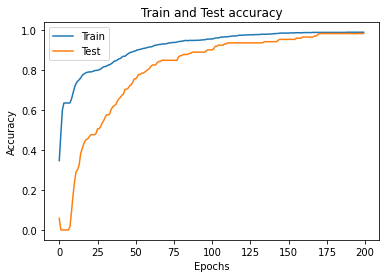

In [25]:
#train vs test accuracy 
epochs = [i for i in range(200)]
plt.plot(epochs,main_loop.accuracy,label = "Train")
plt.plot(epochs,main_loop.test_acc,label = "Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test accuracy")
plt.legend()
plt.show()

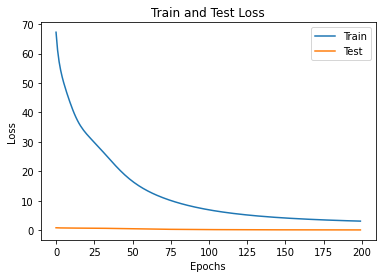

In [29]:
plt.plot(epochs,main_loop.losses,label = "Train")
plt.plot(epochs,main_loop.test_loss,label = "Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.legend()
plt.show()

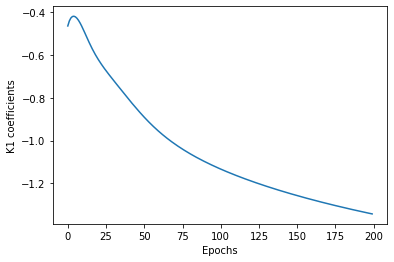

In [27]:
plt.plot(epochs,main_loop.activation_K1)
plt.xlabel("Epochs")
plt.ylabel("K1 coefficients")
plt.show()

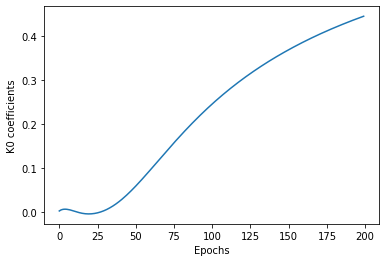

In [28]:
plt.plot(epochs,main_loop.activation_K0)
plt.xlabel("Epochs")
plt.ylabel("K0 coefficients")
plt.show()